<a href="https://colab.research.google.com/github/jdcast/dl-final-project/blob/main/Vanilla_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Mount Google Drive Data
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Mounted at /content/gdrive


In [2]:
## Standard Library
import os
import json
import time

## External Libraries
import numpy as np
from tqdm import tqdm
from scipy.stats import iqr
import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from skimage import io
import matplotlib.pyplot as plt
from PIL import Image

gpu_boole = torch.cuda.is_available()

In [ ]:
#hyper parameters
batch_size = 2

#address of data, i'm using google drive now (following is my direction to dataset)
# data_dir = "/content/gdrive/MyDrive/colab/data/DL_Project/Synthetic_MICCAI2020_dataset/"
data_dir = "/content/gdrive/MyDrive/JHU_DeepLearning_Spring2021/DL_Project/Synthetic_MICCAI2020_dataset/"

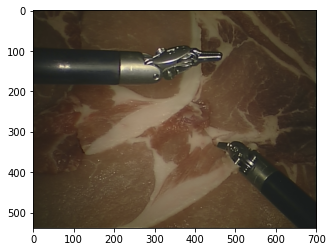

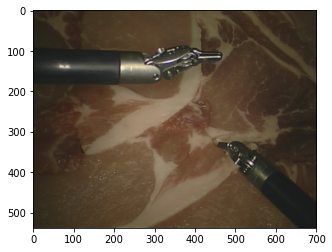

In [ ]:
test_input_data_dir = "/content/gdrive/MyDrive/colab/data/DL_Project/Synthetic_MICCAI2020_dataset/Video_01/images/000.png"
# test_input_data_dir = "/content/gdrive/MyDrive/JHU_DeepLearning_Spring2021/DL_Project/Synthetic_MICCAI2020_dataset/Video_01/images/000.png"

img = Image.open(test_input_data_dir)
plt.imshow(img)
plt.show()
img = TF.gaussian_blur(img, [3, 3])
plt.imshow(img)
plt.show()

In [ ]:
class ImageDataset(Dataset):
    """
    Image Dataset
    """

    def __init__(self, data_dir, op, frame = 10, transform=False, occlusion=False):
        """
        Args:
            input_dir: input data path to images and masks
        """
        assert frame > 1, 'number of frames should be an integer greater than 1'

        self.frame = frame
        self.op = op # specify train or test 
        self.data_dir = data_dir
        self.transform = transform
        if occlusion:
          assert self.frame > 9, 'number of frames should be greater than 9 for occlusion to work'
        self.occlusion = occlusion
        self.occ_frames = 4 # Number of frames to occlude.
        self.occ_box_size = 50
        self.mask_num = 2 # Only 2 output class labels.
        self.h = 256
        self.w = 320
        self.mask_value = {0:0, 1:255}
        
        try:
          if self.op == 'train':
              self.len = 300 * 8 // frame # Videos 1-8 with 300 frames each.
          elif self.op == 'val':
              self.len = 300 * 2 // frame # Videos 9-10.
          elif self.op == 'test':
              self.len = 300 * 4 // frame # Videos 11-14.
        except ValueError:
          print ('op should be train or test.')
    
    
    def __len__(self):
        """
          for training: using videos from 01-08 each with 300 pics (14 * 300 img in total)
          for val: using videos from 09-10 each with 300 pics (6 * 300 img in total)
          for testing: using videos from 11-15 each with 300 pics (6 * 300 img in total)
        """
        return self.len

    def __getitem__(self, idx):
        """
          returning corresponding img and mask from dataset folder 
        """

        video_id = (idx * self.frame) // 300 + 1 #returning the number part of video's name str (i.e. "Video_01"'s '01')

        if self.op == 'train':
            video_name = str(video_id).zfill(2) 
        elif self.op == 'val':
            video_id = (idx * self.frame) // 300 + 9
            video_name = str(video_id).zfill(2)
        else:
            video_id = (idx * self.frame) // 300 + 11
            video_name = str(video_id).zfill(2)
        
        img_dir = self.data_dir + "Video_" + video_name + "/images/"
        mask_dir = self.data_dir + "Video_" + video_name + "/ground_truth/"

        frames = [(idx * self.frame + i) % 300 for i in range(self.frame)]
        # start = np.random.randint(100)
        # interval = np.random.randint(5, 10)
        # print (start, interval)
        # frames = [start for _ in range(self.frame)]

        img, mask = torch.zeros((3, self.frame, self.h, self.w)), torch.zeros((2, len(frames), 256, 320))

        if self.occlusion:
          start = -1
          if np.random.random() > 0.6:
            start = np.random.randint(self.frame - self.occ_frames)

        for i in range(self.frame):

            img_name = img_dir + str(frames[i]).zfill(3) + ".png"
            mask_name = mask_dir + str(frames[i]).zfill(3) + '.png'
            
            img_next = Image.open(img_name)
            mask_next = Image.open(mask_name)

            img_next = TF.resize(img_next, (self.h, self.w), interpolation=TF.InterpolationMode.NEAREST)
            mask_next = TF.resize(mask_next, (self.h, self.w), interpolation=TF.InterpolationMode.NEAREST)
            
            # Apply data augmentations, if any.
            if self.transform:
                img_next, mask_next = self.augment(img_next, mask_next)

            # occlusion
            if self.occlusion and i >= start and i < start + self.occ_frames:
                img_next, mask_next = self.occlude(img_next, mask_next)
            
            mask_next = np.array(mask_next)
            
            # Convert grey-scale label to one-hot encoding
            new_mask = np.zeros((self.h, self.w, self.mask_num))
            for idx in range(self.mask_num):
                new_mask[:, :, idx] = mask_next[:, :, 0] == self.mask_value[idx]

            # Transform to tensor
            img_next = TF.to_tensor(img_next)
            mask_next = TF.to_tensor(new_mask)
            
            img[:, i, :, :] = img_next
            mask[:, i, :, :] = mask_next

        return img, mask

    def augment(self, img, mask):

        
        if np.random.random() > 0.5:

            # # Random horizontal flipping
            # if np.random.random() > 0.5:
            #     img = TF.hflip(img)
            #     mask = TF.hflip(mask)

            # # Random vertical flipping
            # if np.random.random() > 0.5:
            #     img = TF.vflip(img)
            #     mask = TF.vflip(mask)

            # Random brightness change
            if np.random.random() > 0.5:
                img = TF.adjust_brightness(img, np.random.uniform(0.5, 2))

            # Random contrast change
            if np.random.random() > 0.75:
                img = TF.adjust_contrast(img, np.random.uniform(0.5, 2))
            
            # Random hue change
            if np.random.random() > 0.8:
                img = TF.adjust_hue(img, np.random.uniform(-0.3, 0.3))

            # # Random equalize
            # if np.random.random() > 0.9:
            #     img = TF.equalize(img)

            # Random gaussian blur
            if np.random.random() > 0.9:
                img = TF.gaussian_blur(img, [3, 3])
        
        return img, mask

    def occlude(self, img, mask):

        img = np.array(img)
        tool_removed_img = np.where(mask, 0, img)

        min_size = min(self.h, self.w)
        if self.h == min_size:
          coord_h_low, coord_h_high = self.h // 2 - self.h // 3, self.h // 2 + self.h // 3
          coord_w_low, coord_w_high = self.w // 2 - self.h // 3, self.w // 2 + self.h // 3
          slack = self.h - coord_h_high
        else:
          coord_h_low, coord_h_high = self.h // 2 - self.w // 3, self.h // 2 + self.w // 3
          coord_w_low, coord_w_high = self.w // 2 - self.w // 3, self.w // 2 + self.w // 3
          slack = self.w - coord_w_high


        center_img = img[coord_h_low:coord_h_high, coord_w_low:coord_w_high, :]
        center_tool_removed_img = tool_removed_img[coord_h_low:coord_h_high, coord_w_low:coord_w_high, :]
        
        new_center = np.zeros(center_img.shape)
        
        # Flip
        flip = np.random.randint(3)
        if not flip: # horizontal_flip
          flipped_img = np.flip(img, 0)
          flipped_tool_removed_img = np.flip(tool_removed_img, 0)
        elif flip == 1: # vertical flip
          flipped_img = np.flip(img, 1)
          flipped_tool_removed_img = np.flip(tool_removed_img, 1)
        else: # both
          flipped_img = np.flip(img, (0, 1))
          flipped_tool_removed_img = np.flip(tool_removed_img, (0, 1))

        # Rotated center image to paste from.
        rot_center_img = np.rot90(center_img, 1, (0, 1))

        # Translate
        delta = np.random.randint(slack // 4, slack // 2)
        direction = np.random.randint(4)
        if not direction: # Towards bottom right
          coord_h_lowt, coord_w_lowt, coord_h_hight, coord_w_hight = coord_h_low + delta, coord_w_low + delta, coord_h_high + delta, coord_w_high + delta
        elif direction == 1: # Towards top right
          coord_h_lowt, coord_w_lowt, coord_h_hight, coord_w_hight = coord_h_low - delta, coord_w_low + delta, coord_h_high - delta, coord_w_high + delta
        elif direction == 1: # Towards bottom left
          coord_h_lowt, coord_w_lowt, coord_h_hight, coord_w_hight = coord_h_low + delta, coord_w_low - delta, coord_h_high + delta, coord_w_high - delta
        else: # Towards top left
          coord_h_lowt, coord_w_lowt, coord_h_hight, coord_w_hight = coord_h_low - delta, coord_w_low - delta, coord_h_high - delta, coord_w_high - delta

        transformed_center_img = flipped_img[coord_h_lowt:coord_h_hight, coord_w_lowt:coord_w_hight, :]
        transformed_center_tool_removed_img = flipped_tool_removed_img[coord_h_lowt:coord_h_hight, coord_w_lowt:coord_w_hight, :]

        center_new = np.where(center_tool_removed_img == transformed_center_tool_removed_img, rot_center_img, center_img)
        img[coord_h_low:coord_h_high, coord_w_low:coord_w_high, :] = center_new
        
        return img, mask

In [ ]:
train_dataset = ImageDataset(data_dir, op='train', transform=True, occlusion=False)
val_dataset = ImageDataset(data_dir, op='val', transform=False, occlusion=False)
test_dataset = ImageDataset(data_dir, op='test', transform=False, occlusion=False)

train_dataloader = DataLoader(train_dataset,  batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

torch.Size([2, 3, 10, 256, 320]) torch.Size([2, 2, 10, 256, 320])


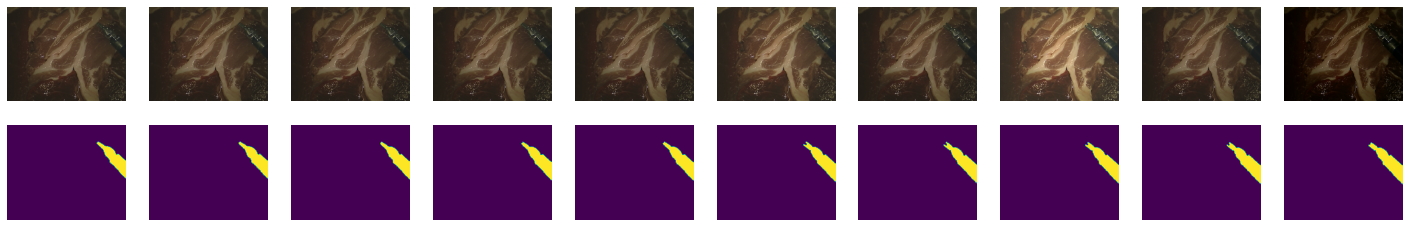

In [ ]:
img, mask = next(iter(train_dataloader))
print (img.shape, mask.shape)
fig, axarr = plt.subplots(2, 10, figsize=(25, 4))
columns = 10
rows = 2

for i in range(rows):
  for j in range(columns):
    if i == 0:
      image = torch.permute(img[0, :, j, :, :], (1, 2, 0)).cpu().numpy()
      axarr[i, j].imshow(image)
      axarr[i, j].axis('off')
    else:
      image = torch.argmax(mask[0], dim=0)[j].cpu().numpy()
      axarr[i, j].imshow(image)
      axarr[i, j].axis('off')

plt.show()

In [ ]:
def dice_score_batch(prediction, target, n_classes):
    '''
      compute the mean dice score for a single batch of frames

      Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
      Args:
          prediction (tensor): predictied labels of the batch
          target (tensor): ground truth of the batch
          n_classes (int): number of classes
    
      Returns:
          m_dice (float): Mean dice score over classes over the batch
    '''
    b, d, _, _ = target.shape

    dice_classes = torch.zeros((b, d, n_classes))
    TP = torch.zeros((b, d, n_classes))
    FP = torch.zeros((b, d, n_classes))
    FN = torch.zeros((b, d, n_classes))
    
    corrects = prediction == target
    incorrects = prediction != target
    
    for k in range(b):
      for j in range(d):
        for cl in range(n_classes):
            p_cl = (prediction == cl)[k][j]
            t_cl = (target == cl)[k][j]
            TP[k][j][cl] = torch.count_nonzero(torch.where(p_cl, corrects[k][j], False))
            FP[k][j][cl] = torch.count_nonzero(torch.where(p_cl, incorrects[k][j], False))
            FN[k][j][cl] = torch.count_nonzero(torch.where(t_cl, incorrects[k][j], False))
    
    for k in range(b):
      for j in range(d):
        for cl in range(n_classes):
            if FP[k][j][cl] == 0 and FN[k][j][cl] == 0:
                dice_classes[k][j][cl] = 1
            else:
                dice_classes[k][j][cl] = 2 * TP[k][j][cl] / (TP[k][j][cl] + FP[k][j][cl] + TP[k][j][cl] + FN[k][j][cl])
    
    return dice_classes.mean(dim=-1)



def dice_score_dataset(model, dataloader, num_classes=2, use_gpu=True):
    """
    Compute the mean dice score on a set of data.
    
    Note that multiclass dice score can be defined as the mean over classes of binary
    dice score. Dice score is computed per image. Mean dice score over the dataset is the dice
    score averaged across all images.
    
    Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
     
    Args:
        model (UNET class): Your trained model
        dataloader (DataLoader): Dataset for evaluation
        num_classes (int): Number of classes
    
    Returns:
        m_dice (float): Mean dice score over the input dataset
    """
    
    ## Number of Batches and Cache over Dataset 
    n_batches = len(dataloader)
    scores = None
    
    ## Evaluate
    model.eval()
    for data in dataloader:
        ## Format Data
        img, target = data
        if use_gpu:
            img = img.cuda()
            target = target.cuda()
        ## Make Predictions
        out = model(img)
        n_classes = out.shape[1]
        prediction = torch.argmax(out, dim = 1)
        target = torch.argmax(target, dim = 1)
        b, d, _, _ = prediction.shape
        score_batch = iou_score_batch(prediction, target, n_classes)
        if i == 0:
          scores = score_batch.flatten()
        else:
          scores = torch.cat((score_batch.flatten(), scores))
    ## Average Dice Score Over Images
    m_dice = scores
    return m_dice

def iou_score_batch(prediction, target, n_classes):
    '''
      compute the mean iou score for a single batch of frames

      Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
      Args:
          prediction (tensor): predictied labels of the batch
          target (tensor): ground truth of the batch
          n_classes (int): number of classes
    
      Returns:
          m_iou (float): Mean iou score over classes over the batch
    '''
    b, d, _, _ = target.shape

    iou_classes = torch.zeros((b, d, n_classes))
    TP = torch.zeros((b, d, n_classes))
    FP = torch.zeros((b, d, n_classes))
    FN = torch.zeros((b, d, n_classes))
    
    corrects = prediction == target
    incorrects = prediction != target
    
    for k in range(b):
      for j in range(d):
        for cl in range(n_classes):
            p_cl = (prediction == cl)[k][j]
            t_cl = (target == cl)[k][j]
            TP[k][j][cl] = torch.count_nonzero(torch.where(p_cl, corrects[k][j], False))
            FP[k][j][cl] = torch.count_nonzero(torch.where(p_cl, incorrects[k][j], False))
            FN[k][j][cl] = torch.count_nonzero(torch.where(t_cl, incorrects[k][j], False))
    
    for k in range(b):
      for j in range(d):
        for cl in range(n_classes):
            if FP[k][j][cl] == 0 and FN[k][j][cl] == 0:
                iou_classes[k][j][cl] = 1
            else:
                iou_classes[k][j][cl] = TP[k][j][cl] / (TP[k][j][cl] + FP[k][j][cl] + FN[k][j][cl])
    
    return iou_classes.mean(dim=-1)

def iou_score_dataset(model, dataloader, num_classes=2, use_gpu=True):
    """
    Compute the mean iou score on a set of data.
    
    Note that multiclass iou score can be defined as the mean over classes of binary
    iou score. iou score is computed per image. Mean iou score over the dataset is the iou
    score averaged across all images.
    
    Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
     
    Args:
        model (UNET class): Your trained model
        dataloader (DataLoader): Dataset for evaluation
        num_classes (int): Number of classes
    
    Returns:
        m_iou (float): Mean iou score over the input dataset
    """
    
    ## Number of Batches and Cache over Dataset 
    n_batches = len(dataloader)
    scores = None
    
    ## Evaluate
    model.eval()
    for i, data in enumerate(dataloader):
        img, target = data
        if use_gpu:
            img = img.cuda()
            target = target.cuda()
        ## Make Predictions
        out = model(img)
        n_classes = out.shape[1]
        prediction = torch.argmax(out, dim = 1)
        target = torch.argmax(target, dim = 1)
        b, d, _, _ = prediction.shape
        score_batch = iou_score_batch(prediction, target, n_classes)
        if i == 0:
          scores = score_batch.flatten()
        else:
          scores = torch.cat((score_batch.flatten(), scores))
    ## Average iou Score Over Images
    m_iou = scores
    return m_iou


class DICELoss(nn.Module):
    def __init__(self):
        super(DICELoss, self).__init__()
        self.eps = 1e-8
        
    def forward(self, pred, target):
        # Expecting in the form [batch_size, channel, d, h, w]
        
        pred = functional.softmax(pred, dim=1)
        
        num = torch.sum(pred * target, dim=(1, 3, 4))
        den = torch.sum(pred**2 + target**2, dim=(1, 3, 4)) / 2
        
        return 1 - ((num + self.eps) / (den + self.eps)).mean()

In [ ]:
## Functions for adding the convolution layer
def add_conv_stage(dim_in,
                   dim_out,
                   kernel_size=3,
                   stride=1,
                   padding='same',
                   bias=True,
                   useBN=True):
    """
    
    """
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv3d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm3d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv3d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm3d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv3d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv3d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )

class Vanilla_UNet(nn.Module):
    def __init__(self, loss='dice', useBN=True, usenoise=False, noiseprob=0.25):
        super(Vanilla_UNet, self).__init__()

        # Downgrade stages
        if useBN:
          self.conv1 = nn.Sequential(
            nn.Conv3d(3, 32, kernel_size=3, stride=(1, 2, 2), padding=1, bias=True),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(0.1))
        else:
          self.conv1 = nn.Sequential(
            nn.Conv3d(3, 32, kernel_size=3, stride=(1, 2, 2), padding=1, bias=True),
            nn.LeakyReLU(0.1))
        
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = add_conv_stage(128, 256, useBN=useBN)
        self.conv5 = add_conv_stage(256, 512, useBN=useBN)

        # Conv layers for concat.
        self.cs1 = nn.Sequential(
            nn.Conv3d(32, 32, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(0.1))
        self.cs2 = nn.Sequential(
            nn.Conv3d(64, 64, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(0.1))
        self.cs3 = nn.Sequential(
            nn.Conv3d(128, 128, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.1))
        self.cs4 = nn.Sequential(
            nn.Conv3d(256, 256, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.1))
        # self.cs5 = nn.Sequential(
        #     nn.Conv3d(512, 512, kernel_size=1, stride=1, padding=0, bias=True),
        #     nn.BatchNorm3d(512),
        #     nn.LeakyReLU(0.1))

        # Upgrade stages
        self.conv4m = add_conv_stage(512, 256, useBN=useBN)
        self.conv3m = add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        
        # Maxpool
        self.max_pool122 = nn.MaxPool3d(2, stride=(1, 2, 2))
        self.max_pool2 = nn.MaxPool3d(2)
        
        # Upsample layers
        self.upsample54 = nn.Sequential(
                    nn.Upsample(scale_factor=2),
                    nn.Conv3d(512, 256, kernel_size=3, padding='same', bias=True),
                    nn.ReLU())
        self.upsample43 = nn.Sequential(
                    nn.Upsample(scale_factor=2),
                    nn.Conv3d(256, 128, kernel_size=3, padding='same', bias=True),
                    nn.ReLU())
        self.upsample32 = nn.Sequential(
                    nn.Upsample(size=(5, 64, 80)),
                    nn.Conv3d(128, 64, kernel_size=3, padding='same', bias=True),
                    nn.ReLU())
        self.upsample21 = nn.Sequential(
                    nn.Upsample(scale_factor=2),
                    nn.Conv3d(64, 32, kernel_size=3, padding='same', bias=True),
                    nn.ReLU())
        
        self.upsample10 = nn.Sequential(
                    nn.Upsample(size=(10, 256, 320)),
                    nn.Conv3d(32, 16, kernel_size=3, padding='same', bias=True),
                    nn.BatchNorm3d(16),
                    nn.ReLU())


        # weight initialization
        # You can have your own weight intialization. This is just an example.
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()
                torch.nn.init.kaiming_uniform_(m.weight.data)

        # Final layer.
        self.conv_fin = nn.Conv3d(16, 2, 1)
        self.dice_loss = DICELoss()
        self.mse_loss = nn.MSELoss()
        self.loss = self.dice_loss
        if loss == 'mse':
          self.loss = self.mse_loss

        self.usenoise = usenoise
        self.noiseprob = noiseprob
        
    
    def forward(self, inputs):

        """
        Forward pass
        """
        conv1_out = self.conv1(inputs)
        conv2_out = self.conv2(self.max_pool2(conv1_out))
        conv3_out = self.conv3(self.max_pool122(conv2_out))
        conv4_out = self.conv4(self.max_pool2(conv3_out))
        conv5_out = self.conv5(self.max_pool2(conv4_out))

        if self.usenoise:
          if self.training:
            if torch.rand(1)[0] < self.noiseprob:
              var = torch.var(conv5_out).item()
              noise = torch.normal(0, var / 10, size=conv5_out.size()).to(conv5_out.device)
              conv5_out += noise

        cs1_out = self.cs1(conv1_out)
        cs2_out = self.cs2(conv2_out)
        cs3_out = self.cs3(conv3_out)
        cs4_out = self.cs4(conv4_out)
        # cs5_out = self.cs5(conv5_out)


        # conv5m_out_ = torch.cat((self.upsample54(conv5_out), conv4_out), 1)
        conv5m_out_ = torch.cat((self.upsample54(conv5_out), cs4_out), 1)
        conv4m_out  = self.conv4m(conv5m_out_)

        # conv4m_out_ = torch.cat((self.upsample43(conv4m_out), conv3_out), 1)
        conv4m_out_ = torch.cat((self.upsample43(conv4m_out), cs3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)

        # conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), cs2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)

        # conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), cs1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)

        conv0m_out = self.upsample10(conv1m_out)

        out = self.conv_fin(conv0m_out)

        return out
        

In [ ]:
## Initialize your unet
# model = Vanilla_UNet(usenoise=True)
# model = torch.load('/content/gdrive/MyDrive/colab/data/DL_Project/runs/final_with_cs_20_epochs.pt')
# model.load_state_dict(torch.load('/content/gdrive/MyDrive/colab/data/DL_Project/runs/final_with_cs_20_epochs_state_dict.pt')['model_state_dict'], strict=False)
# if gpu_boole:
#   model = model.cuda()

# Initialize Optimizer and Learning Rate Scheduler
# optimizer = torch.optim.Adam(model.parameters(),lr=0.005)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

#number of epochs to train for:
num_epochs = 5

#defining epoch train loss recording arrays for later visualization/plotting:
# train_losses = []
# val_losses = []

print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    time1 = time.time()

    mean_loss = 0
    count = 0
    model.train()
    for i, (x,y) in tqdm(enumerate(train_dataloader)):
        if gpu_boole:
          x = x.cuda()
          y = y.cuda()

        # loss calculation and gradient update:
        if i > 0 or epoch > 0:
          optimizer.zero_grad()
        outputs = model.forward(x)

        loss = model.loss(outputs, y)
        loss.backward()

        mean_loss += loss.item()
        count += 1

        ##performing update:
        optimizer.step()

    mean_loss /= count
    train_losses.append(mean_loss)
    print("Epoch",epoch+1,':')
    print ("Train loss:", mean_loss)
    mean_loss = 0
    count = 0
    model.eval()
    for i, (x, y) in tqdm(enumerate(val_dataloader)):
        if gpu_boole:
          x = x.cuda()
          y = y.cuda()
        outputs = model.forward(x)
        loss = model.loss(outputs, y)
        mean_loss += loss.item()
        count += 1
    
    mean_loss /= count
    val_losses.append(mean_loss)
    print ("Val loss:", mean_loss)
    time2 = time.time()
    print('Elapsed time:',time2 - time1,'s')
    print('ETA of completion:',(time2 - time1)*(num_epochs - epoch - 1)/60,'minutes')

Start Training...

EPOCH 1 of 5



120it [01:26,  1.38it/s]

Epoch 1 :
Train loss: 0.00653425802787145



30it [00:05,  5.18it/s]

Val loss: 0.007703107595443725
Elapsed time: 92.92301774024963 s
ETA of completion: 6.194867849349976 minutes

EPOCH 2 of 5




120it [01:29,  1.34it/s]

Epoch 2 :
Train loss: 0.0072230234742164615



30it [00:05,  5.09it/s]

Val loss: 0.04561456640561422
Elapsed time: 95.5414662361145 s
ETA of completion: 4.777073311805725 minutes

EPOCH 3 of 5




120it [01:29,  1.34it/s]

Epoch 3 :
Train loss: 0.00908259799083074



30it [00:06,  5.00it/s]

Val loss: 0.029536304871241252
Elapsed time: 95.81996989250183 s
ETA of completion: 3.193998996416728 minutes

EPOCH 4 of 5




120it [01:29,  1.34it/s]

Epoch 4 :
Train loss: 0.006755233307679494



30it [00:05,  5.09it/s]

Val loss: 0.008524797360102336
Elapsed time: 95.63174390792847 s
ETA of completion: 1.5938623984654745 minutes

EPOCH 5 of 5




120it [01:29,  1.34it/s]

Epoch 5 :
Train loss: 0.006401169300079346



30it [00:05,  5.01it/s]

Val loss: 0.008909004926681518
Elapsed time: 95.65880012512207 s
ETA of completion: 0.0 minutes


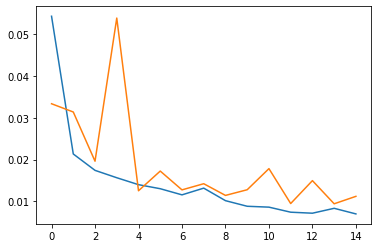

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)

In [ ]:
torch.save(model, '/content/gdrive/MyDrive/colab/data/DL_Project/runs/final_with_cs_occlusion_20_epochs.pt')

In [ ]:
# model = torch.load('/content/gdrive/MyDrive/colab/data/DL_Project/runs/final_with_cs_20_epochs.pt')
# model = torch.load('/content/gdrive/MyDrive/colab/data/DL_Project/runs/final_with_cs_occlusion_20_epochs.pt')
model = Vanilla_UNet()
# model.load_state_dict(torch.load('/content/gdrive/MyDrive/colab/data/DL_Project/runs/final_with_cs_occlusion_20_epochs_state_dict.pt')['model_state_dict'], strict=False)
# model.load_state_dict(torch.load('/content/gdrive/MyDrive/colab/data/DL_Project/runs/final_with_cs_20_epochs_state_dict.pt')['model_state_dict'], strict=False)
# model.load_state_dict(torch.load('/content/gdrive/MyDrive/JHU_DeepLearning_Spring2021/DL_Project/runs/final_with_cs_20_epochs_state_dict.pt')['model_state_dict'], strict=False)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/JHU_DeepLearning_Spring2021/DL_Project/runs/final_with_cs_occlusion_20_epochs_state_dict.pt')['model_state_dict'], strict=False)
# torch.save({'epoch': 20,
#             'model_state_dict': model.state_dict()},
#             '/content/gdrive/MyDrive/colab/data/DL_Project/runs/final_with_cs_occlusion_20_epochs_state_dict.pt')
# dict_ = torch.load('/content/gdrive/MyDrive/colab/data/DL_Project/runs/fin_with_goodaugment_20epochs.pt')
# dict_ = dict_['unet']

# model.load_state_dict(dict_)

if gpu_boole:
  model = model.cuda()

model.eval()

Vanilla_UNet(
  (conv1): Sequential(
    (0): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (conv2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv3): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=

In [ ]:
print (len(test_dataloader))
img, mask = test_dataset[70]
# img, mask = test_dataset[111]
img = torch.unsqueeze(img, 0)
mask = torch.unsqueeze(mask, 0)
if gpu_boole:
  img = img.cuda()
  mask = mask.cuda()
out = model.forward(img)
print (img.shape, mask.shape, out.shape)

60
torch.Size([1, 3, 10, 256, 320]) torch.Size([1, 2, 10, 256, 320]) torch.Size([1, 2, 10, 256, 320])


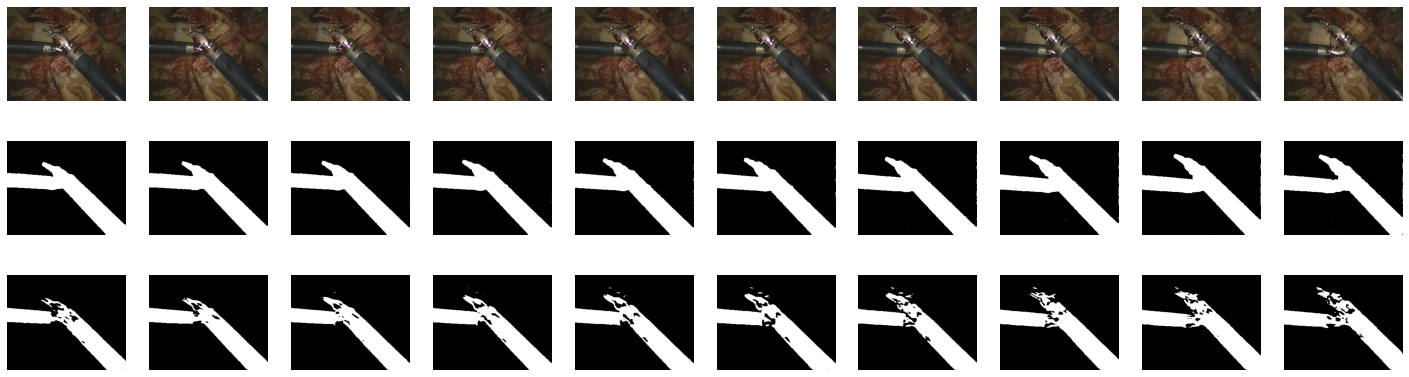

In [ ]:
fig, axarr = plt.subplots(3, 10, figsize=(25, 7))
columns = 10
rows = 3

for i in range(rows):
  for j in range(columns):
    if i == 0:
      image = torch.permute(img[0, :, j, :, :], (1, 2, 0)).cpu().numpy()
      axarr[i, j].imshow(image, cmap='gray')
      axarr[i, j].axis('off')
    elif i == 1:
      image = torch.argmax(mask[0], dim=0)[j].cpu().numpy()
      gt = np.zeros((image.shape[0], image.shape[1], 3))
      for idx in range(2):
        filter_map = image == idx
        gt[filter_map] = float(idx)
      axarr[i, j].imshow(image, cmap='gray')
      axarr[i, j].axis('off')
    else:
      image = torch.argmax(out[0], dim=0)[j].cpu().numpy()
      outt = np.zeros((image.shape[0], image.shape[1], 3))
      for idx in range(2):
        filter_map = image == idx
        outt[filter_map] = float(idx)
      axarr[i, j].imshow(image, cmap='gray')
      axarr[i, j].axis('off')
      

plt.show()

In [ ]:
iou_score = iou_score_dataset(model, test_dataloader)

In [ ]:
for i in range(0, len(iou_score), 300):
  print (np.median(iou_score[i:i + 300]))
  print (iqr(iou_score[i:i + 300]))

print (np.median(iou_score))
print (iqr(iou_score))

0.94435906
0.03603425621986389
0.90845656
0.03684741258621216
0.83916795
0.0411892831325531
0.86925936
0.06364114582538605
0.8878521
0.0772080272436142


In [ ]:
for data in tqdm(train_dataloader):
  continue

100%|██████████| 120/120 [06:33<00:00,  3.28s/it]


In [10]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [15]:
train_embeddings = np.load('/content/gdrive/MyDrive/JHU/Courses/Deep Learning/DL_Project/CPC_3D_encoder_embeddings/10_frames/1651689411_116581/train_embeddings.npy')

train_embeddings = np.reshape(train_embeddings, (train_embeddings.shape[0], -1))

kmeans = KMeans(n_clusters=2, random_state=0).fit(train_embeddings)

print(kmeans.labels_)

tsne = TSNE(learning_rate='auto', init='pca', verbose=1)
tre = tsne.fit_transform(train_embeddings)

[0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 240 samples in 0.011s...
[t-SNE] Computed neighbors for 240 samples in 0.286s...
[t-SNE] Computed conditional probabilities for sample 240 / 240
[t-SNE] Mean sigma: 21.446320


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.161621
[t-SNE] KL divergence after 1000 iterations: 0.506225


[  0   1   2   3   5   7   8  10  11  12  15  16  17  18  19  20  22  23
  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41
  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59
  67  69  70  71  72  73  78  79  88  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 106 107 108 109 110 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 234 235 236 237 238 239]


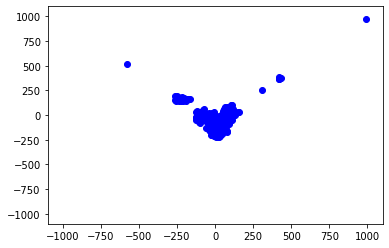

In [22]:
print(np.arange(240)[kmeans.labels_ == 0])
plt.xlim((-1100, 1100))
plt.ylim((-1100, 1100))
for i in range(len(tre)):
  plt.scatter(tre[i, 0], tre[i, 1], color='blue')
plt.show()